In [2]:
import random
import csv
import math

# Grid layout
rows, cols = 10, 10
N = rows * cols

# Simulation parameters
baseline_quality = 0.6
quality_variation = 0.2
timesteps = 20
decay_memory = 0.1

# Initialize audience with position, skepticism, sociability and memory
audience = [{
    "id": i,
    "row": i // cols,
    "col": i % cols,
    "stood": False,
    "skepticism": random.uniform(0.3, 0.9),
    "sociability": random.uniform(0.5, 1.0),
    "memory": 0.0
} for i in range(N)]

results = []

for t in range(timesteps):
    # dynamic performance quality (sinusoidal + noise)
    quality = (baseline_quality
               + quality_variation * math.sin(2 * math.pi * t / timesteps)
               + random.uniform(-0.05, 0.05))
    standing = 0

    for person in audience:
        if not person["stood"]:
            # 8-neighbor social influence
            r, c = person["row"], person["col"]
            neighbors = [
                p for p in audience
                if abs(p["row"] - r) <= 1
                and abs(p["col"] - c) <= 1
                and p["id"] != person["id"]
            ]
            influence = (sum(n["stood"] * n["sociability"] for n in neighbors) / len(neighbors)) if neighbors else 0

            # decision score = quality + social + memory – cost of skepticism
            score = quality + influence + person["memory"] - 0.1 * person["skepticism"]
            threshold = person["skepticism"] * random.uniform(0.9, 1.1)

            if score > threshold:
                person["stood"] = True

        if person["stood"]:
            standing += 1
            # build memory of standing
            person["memory"] = min(1.0, person["memory"] + decay_memory)

    avg_skept = sum(p["skepticism"] for p in audience if p["stood"]) / (standing or 1)
    results.append({
        "timestep": t,
        "standing": standing,
        "seated": N - standing,
        "avg_skepticism": round(avg_skept, 3),
        "quality": round(quality, 3)
    })

# write out extended metrics
with open("SimulationResults.csv", "w", newline='') as f:
    writer = csv.DictWriter(
        f,
        fieldnames=["timestep", "standing", "seated", "avg_skepticism", "quality"]
    )
    writer.writeheader()
    writer.writerows(results)

print("Simulation complete: neighbor influence, dynamic quality, memory effects saved.")


Simulation complete: neighbor influence, dynamic quality, memory effects saved.


In [5]:
import random
import csv
import math

# Grid layout
rows, cols = 10, 10
N = rows * cols

# Simulation parameters
baseline_quality   = 0.5       # start‐of‐show sound‐check level
quality_peak       = 1.0       # max energy
rise_fraction      = 0.4       # fraction of timesteps to reach peak
timesteps          = 50        # longer show
decay_memory       = 0.05      # memory builds slowly
social_weight      = 0.3       # social influence multiplier
seed_rate          = 0.2       # initial chance a front‐row person stands

# Initialize audience
audience = [
    {
        "id":         i,
        "row":        i // cols,
        "col":        i % cols,
        "stood":      False,
        "skepticism": random.uniform(0.3, 0.9),
        "sociability":random.uniform(0.5, 1.0),
        "memory":     0.0
    }
    for i in range(N)
]

# seed a few front‐row clappers at t=0
for p in audience:
    if p["row"] == 0 and random.random() < seed_rate:
        p["stood"]  = True
        p["memory"] = decay_memory

results = []

for t in range(timesteps):
    # quality ramps up to peak then plateaus + small noise
    frac = min(1.0, t / (rise_fraction * timesteps))
    quality = baseline_quality + (quality_peak - baseline_quality) * frac
    quality += random.uniform(-0.02, 0.02)
    quality = max(0.0, min(1.0, quality))

    standing = sum(p["stood"] for p in audience)

    for person in audience:
        if not person["stood"]:
            # 8‐neighbor social influence
            r, c = person["row"], person["col"]
            nbrs = [
                q for q in audience
                if abs(q["row"] - r) <= 1
                and abs(q["col"] - c) <= 1
                and q["id"] != person["id"]
            ]
            influence = (
                sum(q["stood"] * q["sociability"] for q in nbrs) / len(nbrs)
            ) if nbrs else 0

            # decision score
            score     = quality \
                        + social_weight * influence \
                        + person["memory"] \
                        - 0.1 * person["skepticism"]

            threshold = person["skepticism"] * random.uniform(0.9, 1.1)
            if score > threshold:
                person["stood"] = True
                standing += 1

        # build memory of having stood
        if person["stood"]:
            person["memory"] = min(1.0, person["memory"] + decay_memory)

    avg_skept = sum(p["skepticism"] for p in audience if p["stood"]) / (standing or 1)
    results.append({
        "timestep":       t,
        "standing":       standing,
        "seated":         N - standing,
        "avg_skepticism": round(avg_skept, 3),
        "quality":        round(quality, 3)
    })

# write out
if 'f' in globals():
    try:
        if hasattr(f, 'close') and not f.closed:
            f.close()
    except:
        pass

output_path = "SimulationResults.csv"
with open(output_path, "w", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=[
        "timestep", "standing", "seated", "avg_skepticism", "quality"
    ])
    writer.writeheader()
    writer.writerows(results)

print(f"Simulation complete ({timesteps} steps), results in {output_path}")


Simulation complete (50 steps), results in SimulationResults.csv


In [6]:
# …existing imports…
import numpy as np

# after you define audience and before the loops:
grid_states = []

# --- Performance loop ---
for t in range(timesteps):
    # … your existing performance code …
    # at the end of this iteration, capture the grid:
    grid = np.array([p["stood"] for p in audience]).reshape(rows, cols)
    grid_states.append(grid)

# --- Applause spread from front to back ---
for r in range(rows):
    # … your existing applause code …
    # capture the grid after each row flips:
    grid = np.array([p["stood"] for p in audience]).reshape(rows, cols)
    grid_states.append(grid)

# … then write out results as you already do …

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(5,5))
cax = ax.imshow(grid_states[0], cmap='Blues', vmin=0, vmax=1)
ax.set_title("Applause Spread Over Time")

def update(frame):
    cax.set_data(grid_states[frame])
    ax.set_xlabel(f"Timestep {frame}")

ani = animation.FuncAnimation(fig, update, frames=len(grid_states), interval=400, blit=False)
plt.close(fig)

# display inline in Jupyter
HTML(ani.to_jshtml())

In [8]:
import random
import csv

# Simulation parameters
ROWS = 10
COLS = 10
TIMESTEPS = 10
INITIAL_SEEDS = 5  # number of random seats that start applauding

# Initialize grid: False = seated, True = applauding
grid = [[False for _ in range(COLS)] for _ in range(ROWS)]

# Seed initial applauders
seeds = set()
while len(seeds) < INITIAL_SEEDS:
    r = random.randrange(ROWS)
    c = random.randrange(COLS)
    seeds.add((r, c))
for (r, c) in seeds:
    grid[r][c] = True

# Utility to get neighbors (N, S, E, W)
def get_neighbors(r, c):
    for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < ROWS and 0 <= nc < COLS:
            yield nr, nc

# Record simulation results
results = []

for t in range(TIMESTEPS):
    # Count current applauders
    num_applauding = sum(grid[r][c] for r in range(ROWS) for c in range(COLS))
    results.append({"timestep": t, "applauding": num_applauding, "seated": ROWS*COLS - num_applauding})
    
    # Prepare next state
    new_grid = [row.copy() for row in grid]
    
    # Spread applause
    for r in range(ROWS):
        for c in range(COLS):
            if grid[r][c]:
                for nr, nc in get_neighbors(r, c):
                    # neighbor starts applauding
                    new_grid[nr][nc] = True
    
    grid = new_grid

# Write results to CSV
with open("SimulationResultsTest.csv", "w", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["timestep", "applauding", "seated"])
    writer.writeheader()
    writer.writerows(results)

print("Simulation complete. Results saved to SimulationResultsTest.csv.")


Simulation complete. Results saved to SimulationResultsTest.csv.


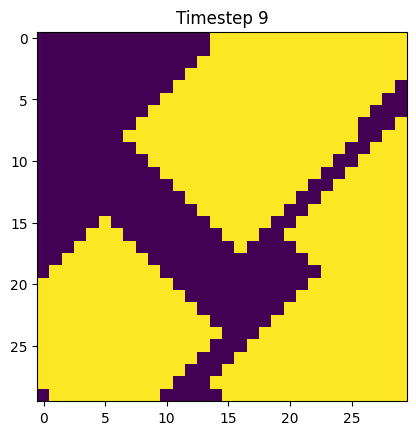

In [12]:
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Simulation parameters
ROWS, COLS = 30, 30
TIMESTEPS = 10
INITIAL_SEEDS = 5  # number of random seats that start applauding

# Initialize grid and seed initial applauders
grid = [[False for _ in range(COLS)] for _ in range(ROWS)]
seeds = set()
while len(seeds) < INITIAL_SEEDS:
    r, c = random.randrange(ROWS), random.randrange(COLS)
    seeds.add((r, c))
for r, c in seeds:
    grid[r][c] = True

# Utility to get neighbors (N, S, E, W)
def get_neighbors(r, c):
    for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < ROWS and 0 <= nc < COLS:
            yield nr, nc

# Run simulation and record states
states = []
current_grid = [row.copy() for row in grid]
for t in range(TIMESTEPS):
    states.append([[1 if current_grid[r][c] else 0 for c in range(COLS)] for r in range(ROWS)])
    new_grid = [row.copy() for row in current_grid]
    for r in range(ROWS):
        for c in range(COLS):
            if current_grid[r][c]:
                for nr, nc in get_neighbors(r, c):
                    new_grid[nr][nc] = True
    current_grid = new_grid

# Create animation
fig, ax = plt.subplots()
im = ax.imshow(states[0], interpolation='nearest')
ax.set_title('Timestep 0')

def update(frame):
    im.set_data(states[frame])
    ax.set_title(f'Timestep {frame}')
    return [im]

anim = animation.FuncAnimation(fig, update, frames=len(states), blit=True)

# Display the animation inline
HTML(anim.to_jshtml())



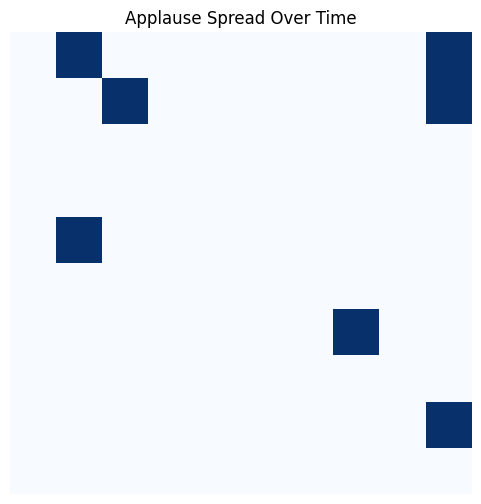

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def simulate_applause(rows=10, cols=10, seed_prob=0.1):
    """
    Initialize a rows×cols grid with random applause seeds (1) 
    and propagate applause to N,S,E,W neighbors until stable.
    Returns a list of grid states at each step.
    """
    grid = np.zeros((rows, cols), dtype=int)
    # initial random seeds
    for r in range(rows):
        for c in range(cols):
            if random.random() < seed_prob:
                grid[r, c] = 1

    states = [grid.copy()]
    while True:
        new_grid = grid.copy()
        for r in range(rows):
            for c in range(cols):
                if grid[r, c] == 0:
                    # check N,S,E,W neighbors
                    for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                        nr, nc = r + dr, c + dc
                        if 0 <= nr < rows and 0 <= nc < cols and grid[nr, nc] == 1:
                            new_grid[r, c] = 1
                            break
        if np.array_equal(new_grid, grid):
            break
        grid = new_grid
        states.append(grid.copy())
    return states

def animate_applause(states, interval=500):
    """
    Animate the list of grid states using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    cax = ax.imshow(states[0], cmap='Blues', vmin=0, vmax=1)
    ax.set_title("Applause Spread Over Time")
    ax.axis('off')

    def update(frame):
        cax.set_data(states[frame])
        ax.set_xlabel(f"Step {frame}", fontsize=10)

    ani = animation.FuncAnimation(fig, update, frames=len(states),
                                  interval=interval, blit=False)
    plt.show()

if __name__ == "__main__":
    random.seed(42)            # for reproducibility
    states = simulate_applause(seed_prob=0.05)
    animate_applause(states)